In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 96
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))


488396 3255 1017 814


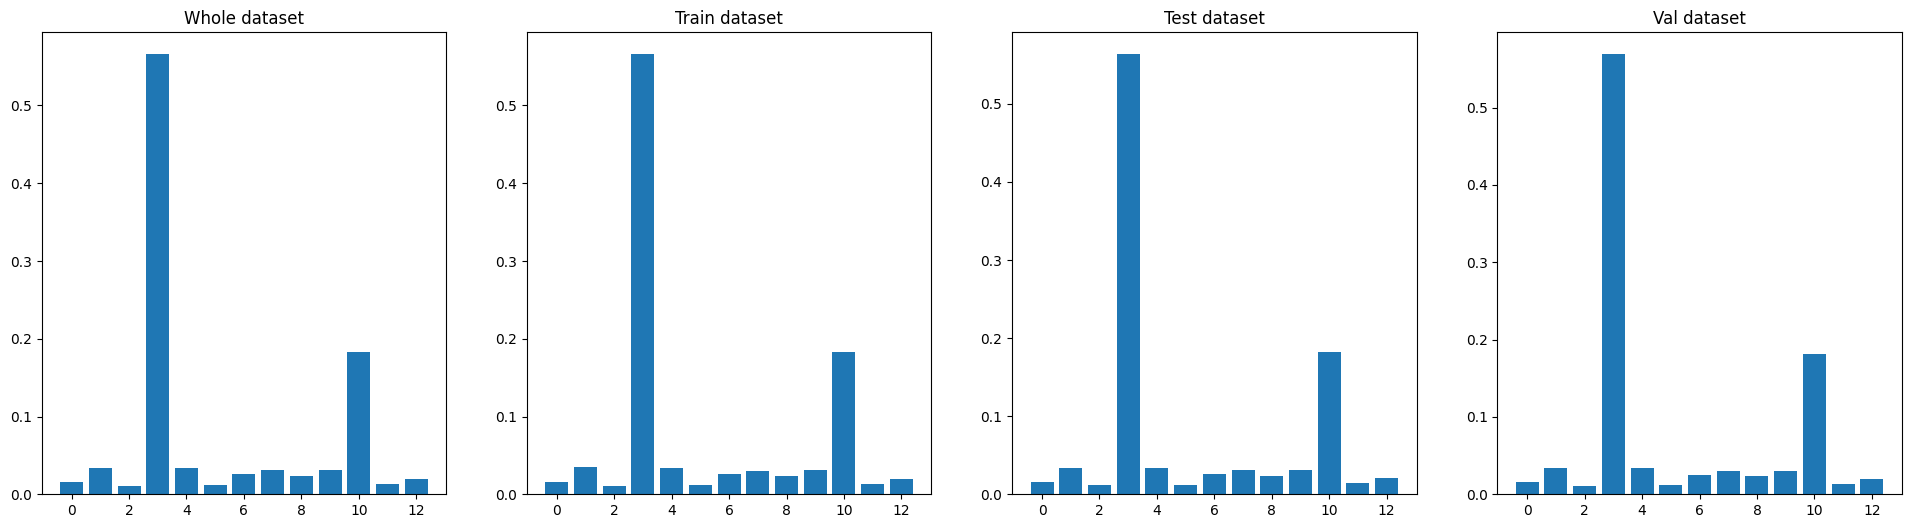

In [3]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

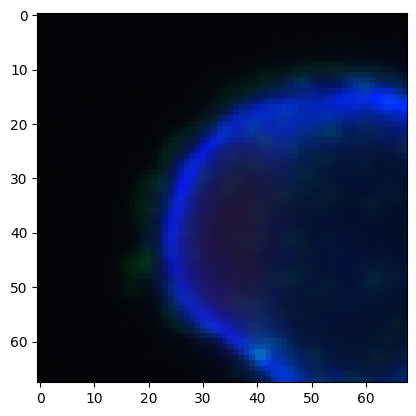

In [4]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [5]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([96, 3, 68, 68]) torch.Size([96])


# VAE

In [6]:
from models import VAE_CELL_CNN
# from loss_functions import loss_function_elbo_3 as loss_function
from loss_functions import loss_function_mean as loss_function
latent_dim = 256
hidden_dim = 2*latent_dim

model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
print(model)

if cuda:
    model = model.cuda()

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=lr)

# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyRe

In [7]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([96, 3, 68, 68])
x_hat.shape: torch.Size([96, 3, 68, 68])


In [8]:
# define dirs for the saving of model / data
MODEL_NAME = f"{model.__class__.__name__}_latent{model.latent_dim}_mean_"
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

print(MODEL_NAME)


VAE_CELL_CNN_latent256_mean_


## Training

In [9]:
val = True

num_epochs = 2
train_loss = []
train_mse_loss = []
train_kld_loss = []
val_loss = []
val_mse_loss = []
val_kld_loss = []

val_train_loss = []
val_train_mse_loss = []
val_train_kld_loss = []


best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)


        optimizer.step()

        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    if val:
        model.eval()
        batch_loss = []
        mse_batch_loss = []
        kld_batch_loss = []

        with torch.no_grad():
            for x, y in val_loader:
                if cuda:
                    x = x.cuda()

                output_val = model(x)
                x_hat, mu, sigma = output_val["x_hat"], output_val["mu"], output_val["sigma"]
                loss_fn = loss_function(x, x_hat, mu, sigma)
                mse_loss = loss_fn["MSE"]
                kld_loss = loss_fn["KLD"]
                loss = loss_fn["loss"]

                batch_loss.append(loss.item())
                mse_batch_loss.append(mse_loss.item())
                kld_batch_loss.append(kld_loss.item())

            val_loss.append(np.mean(batch_loss))
            val_mse_loss.append(np.mean(mse_batch_loss))
            val_kld_loss.append(np.mean(kld_batch_loss))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                # torch.save(model.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}")
    
    # plot_latent(output)



Epoch 1/2, loss: 137.1486066381686, mse_loss: 108.82053438998221, kld_loss: 28.32807185177544, val_loss: 102.87628628405072, val_mse_loss: 72.21611715593268, val_kld_loss: 30.660168211934607
Epoch 2/2, loss: 99.77599483788838, mse_loss: 68.42920439642512, kld_loss: 31.346789880685176, val_loss: 97.43126891227554, val_mse_loss: 65.75858034138598, val_kld_loss: 31.67268806241947


# Evaluate model on test set

In [10]:
# we evaluate model on test set
test_loss = []
test_mse_loss = []
test_kld_loss = []
model.eval()

for x, y in test_loader:
    if cuda:
        x = x.cuda()

    output_test = model(x)
    x_hat, mu, sigma = output_test["x_hat"], output_test["mu"], output_test["sigma"]
    loss_fn = loss_function(x, x_hat, mu, sigma)
    mse_loss = loss_fn["MSE"]
    kld_loss = loss_fn["KLD"]
    loss = loss_fn["loss"]

    test_loss.append(loss.item())
    test_mse_loss.append(mse_loss.item())
    test_kld_loss.append(kld_loss.item())

print(f"Test loss: {np.mean(test_loss)}, Test mse loss: {np.mean(test_mse_loss)}, Test kld loss: {np.mean(test_kld_loss)}")

Test loss: 97.32024386545667, Test mse loss: 65.65086424760996, Test kld loss: 31.669379115221894


## Plots

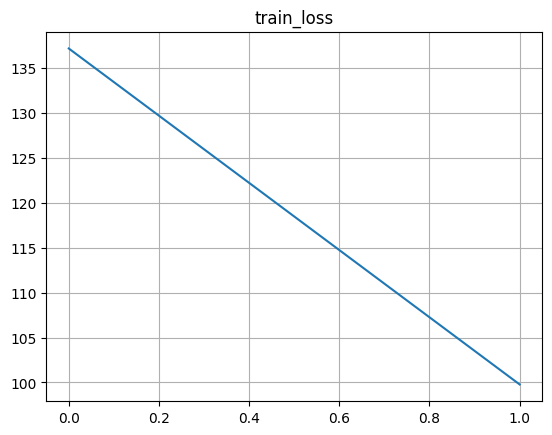

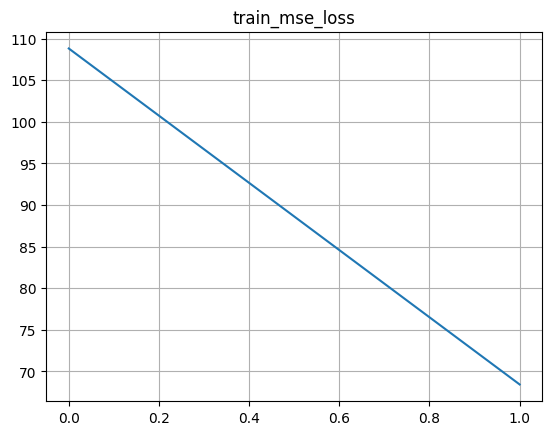

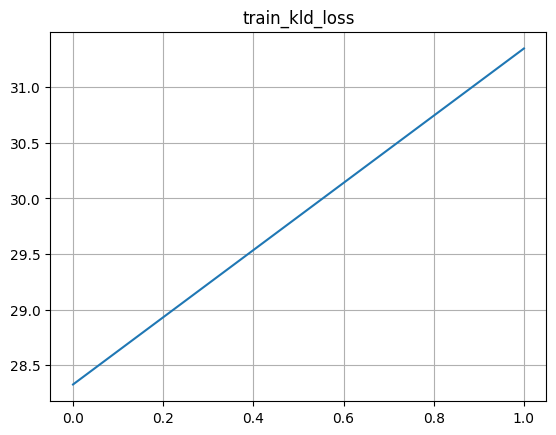

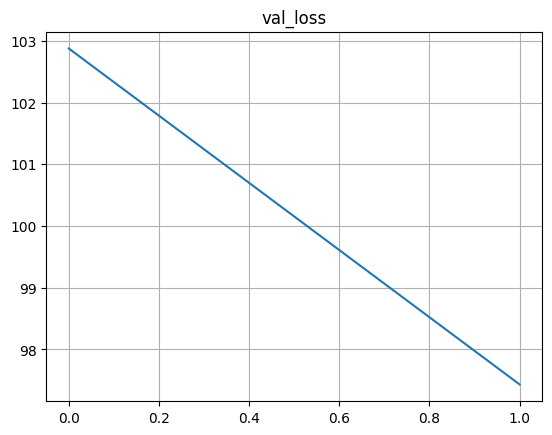

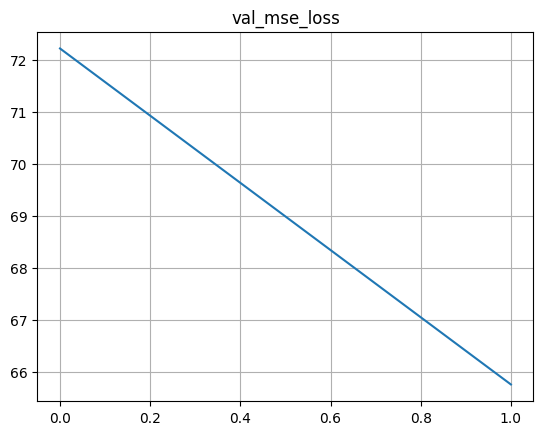

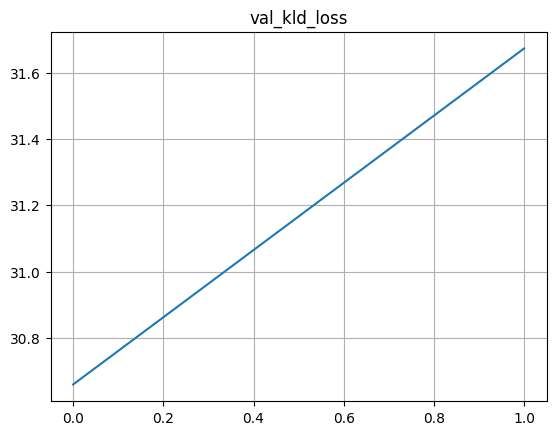

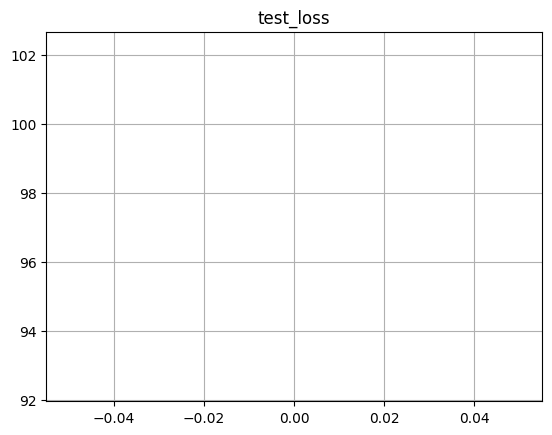

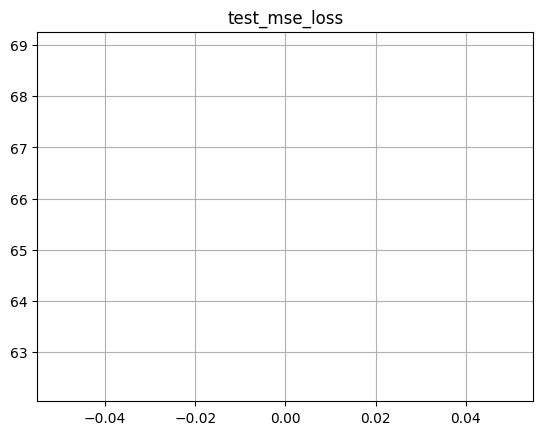

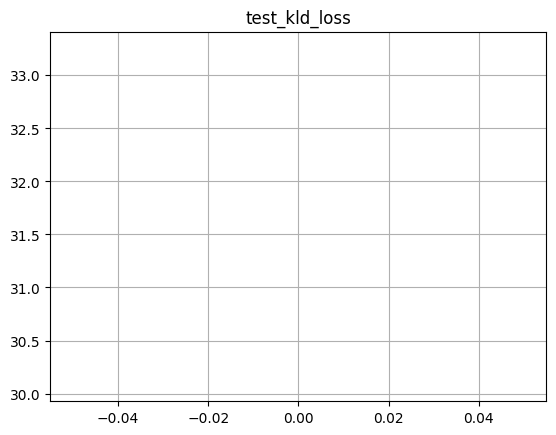

In [11]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss
loss_data["val_loss"] = val_loss
loss_data["val_mse_loss"] = val_mse_loss
loss_data["val_kld_loss"] = val_kld_loss
loss_data["test_loss"] = np.mean(test_loss)
loss_data["test_mse_loss"] = np.mean(test_mse_loss)
loss_data["test_kld_loss"] = np.mean(test_kld_loss)

loss_plots(loss_data, invidual_plots=True, title="")

df = pd.DataFrame(loss_data)
# try:
#     old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv")
#     df = pd.concat([old_df, df])
# except:
#     pass
# df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv", index=False)


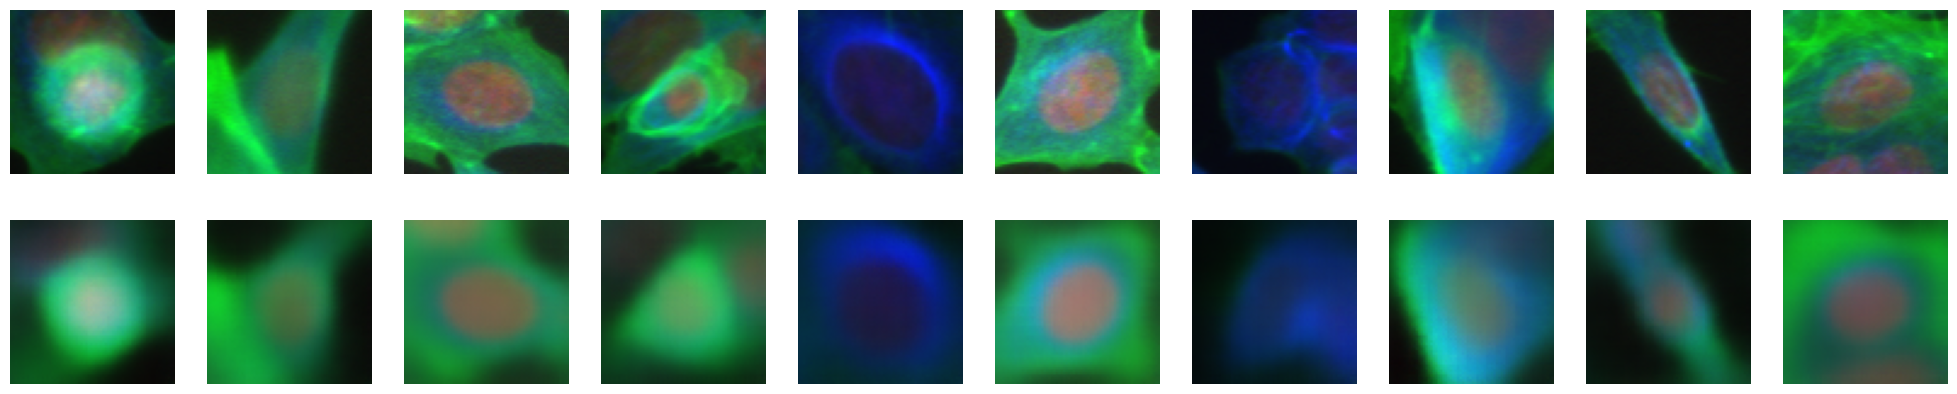

In [12]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))


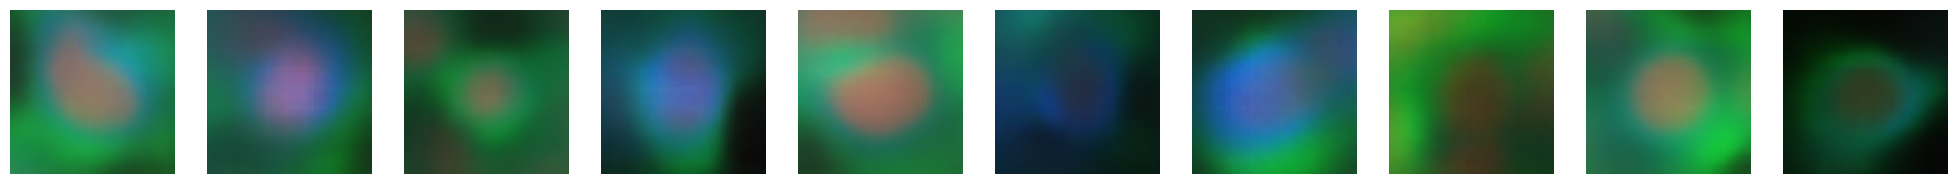

In [13]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [47]:
from collections import defaultdict
import torch

# to run inference on the trained model
class Inference:
    def __init__(self, model, test_loader, num_samples=10):
        self.model = model
        self.model.eval()
        self.model.to('cpu')
        self.num_samples = num_samples
        self.test_loader = test_loader
        self.samples = self.generate_samples()
        
    def generate_samples(self):
        # samples = defaultdict(torch.Tensor)
        class_ids = list(test_loader.dataset.dataset.dataset.class_to_idx.values())
        # samples = defaultdict(lambda: {"x": torch.Tensor(),"x_hat": torch.Tensor(), "mu": torch.Tensor(), "sigma": torch.Tensor(), "z": torch.Tensor()})
        samples = {str(idx_id): {"x": torch.Tensor(),"x_hat": torch.Tensor(), "mu": torch.Tensor(), "sigma": torch.Tensor(), "z": torch.Tensor()} for idx_id in class_ids}
        with torch.no_grad():
            for batch_x, batch_y in self.test_loader:
                # if cuda:
                #     batch_x = batch_x.cuda()
                output = self.model(batch_x)
                batch_x_hat, batch_mu, batch_sigma, batch_z = output["x_hat"], output["mu"], output["sigma"], output["z"]
                while any([len(samples[str(id)]["x"]) < self.num_samples for id in class_ids]):
                    for x, x_hat, y, mu, sigma, z in zip(batch_x, batch_x_hat, batch_y, batch_mu, batch_sigma, batch_z):
                        if len(samples[str(y.item())]["x"]) < self.num_samples:
                            # add the generated image to the list
                            samples[str(y.item())]["x"] = torch.cat((samples[str(y.item())]["x"], x.unsqueeze(0)), dim=0)
                            samples[str(y.item())]["x_hat"] = torch.cat((samples[str(y.item())]["x_hat"], x_hat.unsqueeze(0)), dim=0)
                            samples[str(y.item())]["mu"] = torch.cat((samples[str(y.item())]["mu"], mu.unsqueeze(0)), dim=0)
                            samples[str(y.item())]["sigma"] = torch.cat((samples[str(y.item())]["sigma"], sigma.unsqueeze(0)), dim=0)
                            samples[str(y.item())]["z"] = torch.cat((samples[str(y.item())]["z"], z.unsqueeze(0)), dim=0)
                        else:
                            break
        return samples

In [46]:
# from inference import Inference

inference = Inference(model, test_loader)

In [15]:
samples = inference.samples
samples

In [16]:
show_img(samples['1']["x"])

In [ ]:
# interpolate between two images in the latent space
from scipy.interpolate import interp1d, interp2d

def interpolate_latent(model, z1, z2, num):
    """
    Interpolates between two latent vectors and decodes them
    """

    z = torch.zeros(num, z1.shape[0])
    for i, alpha in enumerate(np.linspace(0, 1, num)):
        z[i] = alpha*z1 + (1-alpha)*z2

    z = z.to('cpu')
    x_hat = model.decode(z)
    return x_hat

x1 = samples['1']["x"][0]
x2 = samples['1']["x"][1]

